In [1]:
import sys
sys.path.append('/eos/home-i03/m/morwat/.local/lib/python3.9/site-packages/')

In [2]:
import tfs
import pandas as pd
import numpy as np
import yaml

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, HBox, VBox, Label, HTML

#define normalised emittance
emitt=3.5e-6
#define gamma
gamma = 7247.364689

In [5]:
path = "/eos/project-c/collimation-team/machine_configurations/LHC_run3/2023/MADX/"

Beam 1:

In [41]:
df_b1 = tfs.read(path+"injection_VELO_6p5/aperture/ap_ir8b1.tfs")

#find position of IP5
ip5_b1 = df_b1.loc[df_b1['NAME'] == 'IP8', 'S'].values[0]

#get rid of undefined values and take only data within 500 m of ip5
indices_b1 = df_b1.index[(df_b1['APER_1'] < 1) & (df_b1['APER_1'] != 0) & (abs((df_b1['S']-ip5_b1)) < 500)].tolist()

s_b1 = (df_b1["S"][indices_b1]-ip5_b1).to_numpy()
aperx_b1 = df_b1["APER_1"][indices_b1].to_numpy()
apery_b1 = df_b1["APER_2"][indices_b1].to_numpy()
x_b1 = df_b1["X"][indices_b1].to_numpy()
y_b1 = df_b1["Y"][indices_b1].to_numpy()

betx_b1 = df_b1["BETX"][indices_b1].to_numpy()
sigmax_b1 = np.sqrt(betx_b1*emitt/gamma)

bety_b1 = df_b1["BETY"][indices_b1].to_numpy()
sigmay_b1 = np.sqrt(bety_b1*emitt/gamma)

Beam 2:

In [42]:
df_b2 = tfs.read(path+"injection_VELO_6p5/aperture/ap_ir8b2.tfs")

#find position of IP5
ip5_b2 = df_b2.loc[df_b2['NAME'] == 'IP8', 'S'].values[0]

#indices_b2 = df_b2.index[(abs(df_b2['S']-ip5_b2) < 500)].tolist()

indices_b2 = df_b2.index[(df_b2['APER_1'] < 1) & (df_b2['APER_1'] != 0) & (abs((df_b2['S']-ip5_b2)) < 500)].tolist()

s_b2 = (df_b2["S"][indices_b2]-ip5_b2).to_numpy()
aperx_b2 = df_b2["APER_1"][indices_b2].to_numpy()
apery_b2 = df_b2["APER_2"][indices_b2].to_numpy()
x_b2 = df_b2["X"][indices_b2].to_numpy()
y_b2 = df_b2["Y"][indices_b2].to_numpy()

betx_b2 = df_b2["BETX"][indices_b2].to_numpy()
sigmax_b2 = np.sqrt(betx_b2*emitt/gamma)

bety_b2 = df_b2["BETY"][indices_b2].to_numpy()
sigmay_b2 = np.sqrt(bety_b2*emitt/gamma)

Collimators:

In [43]:
col_data = '/eos/project-c/collimation-team/machine_configurations/LHC_run3/2023/colldbs/levelling.20.yaml'

with open(col_data, 'r') as file:
    f = yaml.safe_load(file)

#come back to it, make it not manual
cols_b1 = f['collimators']['b1']
df_col = pd.DataFrame(cols_b1)

# Find collimators in IR5
col_ir5 = [col for col in df_col.columns if 'r8' in col or 'l8' in col]
#redefine the collimators dataframe to only include gap and angle
df_col = df_col.loc[['gap', 'angle'], col_ir5]

#find collimators in horizontal and vertical plane
colx = df_col[df_col.columns[df_col.loc['angle'] == 0]]
coly = df_col[df_col.columns[df_col.loc['angle'] == 90]]

xgap = colx.loc['gap'].to_numpy()
xname = df_col.columns[df_col.loc['angle'] == 0].to_numpy()

ygap = coly.loc['gap'].to_numpy()
yname = df_col.columns[df_col.loc['angle'] == 90].to_numpy()

#change the letters to uppercase to facilitate searching
xname = [name.upper() for name in xname]
yname = [name.upper() for name in yname]

s_col = df_b1["S"].to_numpy()
name_col = df_b1["NAME"].to_numpy()

#find the collimators by name in the other file
indx = np.where(np.isin(name_col, xname))[0]
indy = np.where(np.isin(name_col, yname))[0]

#get the positions of the collimators relative to IP5
s_colx = s_col[indx]-ip5_b1
s_coly = s_col[indy]-ip5_b1

#get sigma at the collimator positions and hence calculate the gap in [m]
col_sigmax = sigmax_b1[np.isin(s_b1, s_colx)]
col_gapx = (col_sigmax*xgap)

col_sigmay = sigmax_b1[np.isin(s_b1, s_coly)]
col_gapy = (col_sigmay*ygap)

Machine components:

In [44]:
df = tfs.read('/eos/project-c/collimation-team/machine_configurations/LHC_run3/2023/MADX_thick/injection/all_optics_B1.tfs')

indices = df.index[(abs((df['S']-ip5_b1)) < 500)].tolist()

s = df['S'][indices].to_numpy()-ip5_b1
keyword = df['KEYWORD'][indices].to_numpy()
l = df['L'][indices].to_numpy()
k1l = df['K1L'][indices].to_numpy()
name = df['NAME'][indices].to_numpy()

#get the quadrapole data explicitly since we also need their strength
qp_s = s[np.where(keyword=="QUADRUPOLE")[0]]
qp_l = l[np.where(keyword=="QUADRUPOLE")[0]]
qp_k1l = np.sign(k1l[np.where(keyword=="QUADRUPOLE")[0]]).astype(int)
qp_name = name[np.where(keyword=="QUADRUPOLE")[0]]

Envelopes:

In [45]:
# Function to update the plot based on slider value
def update_plot(change):

    n=change['new']

    xup_b1 = x_b1+n*sigmax_b1
    xdown_b1 = x_b1-n*sigmax_b1
    xup_b2 = x_b2+n*sigmax_b2
    xdown_b2 = x_b2-n*sigmax_b2

    yup_b1 = y_b1+n*sigmay_b1
    ydown_b1 = y_b1-n*sigmay_b1
    yup_b2 = y_b2+n*sigmay_b2
    ydown_b2 = y_b2-n*sigmay_b2
    
    with fig.batch_update():
        fig.data[0].y = xup_b1
        fig.data[1].y = xdown_b1
        fig.data[2].y = xup_b2
        fig.data[3].y = xdown_b2

        fig.data[4].y = yup_b1
        fig.data[5].y = ydown_b1
        fig.data[6].y = yup_b2
        fig.data[7].y = ydown_b2

n_init = 5

### X

xup_b1 = x_b1+n_init*sigmax_b1
xdown_b1 = x_b1-n_init*sigmax_b1

xup_b2 = x_b2+n_init*sigmax_b2
xdown_b2 = x_b2-n_init*sigmax_b2

upperx_b1 = go.Scatter(x=s_b1, y=xup_b1, mode='lines', name='Upper envelope beam 1', fill=None, line=dict(color='rgba(0,0,255,0)'))
lowerx_b1 = go.Scatter(x=s_b1, y=xdown_b1, mode='lines', name='Lower envelope beam 1', line=dict(color='rgba(0,0,255,0)'), fill='tonexty', fillcolor='rgba(0,0,255,0.1)')

upperx_b2 = go.Scatter(x=s_b2, y=xup_b2, mode='lines', name='Upper envelope beam 2', fill=None, line=dict(color='rgba(255,0,0,0)'))
lowerx_b2 = go.Scatter(x=s_b2, y=xdown_b2, mode='lines', name='Lower envelope beam 2', line=dict(color='rgba(255,0,0,0)'), fill='tonexty', fillcolor='rgba(255,0,0,0.1)')

### Y

yup_b1 = y_b1+n_init*sigmay_b1
ydown_b1 = y_b1-n_init*sigmay_b1

yup_b2 = y_b2+n_init*sigmay_b2
ydown_b2 = y_b2-n_init*sigmay_b2

uppery_b1 = go.Scatter(x=s_b1, y=yup_b1, mode='lines', name='Envelope beam 1', fill=None, line=dict(color='rgba(0,0,255,0)'))
lowery_b1 = go.Scatter(x=s_b1, y=ydown_b1, mode='lines', name='Envelope beam 1', line=dict(color='rgba(0,0,255,0)'), fill='tonexty', fillcolor='rgba(0,0,255,0.1)')

uppery_b2 = go.Scatter(x=s_b2, y=yup_b2, mode='lines', name='Envelope beam 2', fill=None, line=dict(color='rgba(255,0,0,0)'))
lowery_b2 = go.Scatter(x=s_b2, y=ydown_b2, mode='lines', name='Envelope beam 2', line=dict(color='rgba(255,0,0,0)'), fill='tonexty', fillcolor='rgba(255,0,0,0.1)')

In [46]:
# Define hover template with customdata
hover_template_b1 = (
    "s: %{x}<br>"
    "x: %{y} m<br>"
    "distance from b1: %{customdata} [σ]"
)

hover_template_b2 = (
    "s: %{x}<br>"
    "x: %{y} m<br>"
    "distance from b2: %{customdata} [σ]"
)


In [47]:
def rescale(crossing_angle, s_angle, x_angle):

    """
    takes crossing angle in microrad
    """
    
    ind = np.where((s_angle >= 0) & (s_angle < 15))
    s_angle = s_angle[ind]
    x_angle = x_angle[ind]

    adjacent = s_angle[-1]
    opposite = adjacent * np.tan(crossing_angle*1e-6)

    factor = opposite/(x_angle[-1]-x_angle[0])

    return factor 

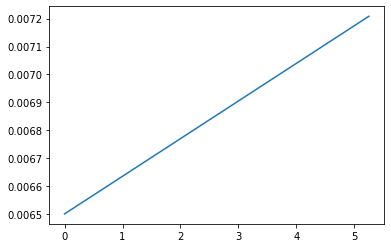

In [48]:
import matplotlib.pyplot as plt
plt.plot(s_b1[np.where((s_b1 >= 0) & (s_b1 < 15))], x_b1[np.where((s_b1 >= 0) & (s_b1 < 15))])

In [49]:
def find_closest_index(array, value):
    # Compute the absolute differences
    differences = np.abs(array - value)
    # Find the index of the smallest difference
    closest_index = np.argmin(differences)
    return closest_index

In [50]:
# Define the tolerance
tolerance = 0.1

# Function to update the plot based on slider value
def update_plot2(change):

    nx=change['new']

    xup_b1 = fig.data[8].y+nx*sigmax_b1
    xdown_b1 = fig.data[8].y-nx*sigmax_b1
    xup_b2 = fig.data[9].y+nx*sigmax_b2
    xdown_b2 = fig.data[9].y-nx*sigmax_b2
    
    with fig.batch_update():
        fig.data[0].y = xup_b1
        fig.data[1].y = xdown_b1
        fig.data[2].y = xup_b2
        fig.data[3].y = xdown_b2

    #calculate the distance from nominal to the edge of the new envelope
    moveddown_b1 = abs((x_b1-xdown_b1)/sigmax_b1)
    movedup_b1 = abs((xup_b1-x_b1)/sigmax_b1)
    movedup_b2 = abs((xup_b2-x_b2)/sigmax_b2)
    moveddown_b2 = abs((x_b2-xdown_b2)/sigmax_b2)

    #calculate the distance from the new envelope to the aperture
    aperdown_b1 = abs((xdown_b1+aperx_b1)/sigmax_b1)
    aperup_b1 = abs((aperx_b1-xup_b1)/sigmax_b1)
    aperdown_b2 = abs((xdown_b2+aperx_b2)/sigmax_b2)
    aperup_b2 = abs((aperx_b2-xup_b2)/sigmax_b2)

    minaper_b1 = np.array([aperdown_b1, aperup_b1])
    minaper_b2 = np.array([aperdown_b2, aperup_b2])

    #get the minimimum
    flat_min_index = np.argmin(minaper_b1)
    row_b1, col_b1 = np.unravel_index(flat_min_index, minaper_b1.shape)

    flat_min_index = np.argmin(minaper_b2)
    row_b2, col_b2 = np.unravel_index(flat_min_index, minaper_b2.shape)

    index_b1 = find_closest_index(s, s_b1[col_b1])
    index_b2 = find_closest_index(s, s_b2[col_b2])

    from_nominal_b1 = max([moveddown_b1[col_b1], movedup_b1[col_b1]])
    from_nominal_b2 = max([moveddown_b2[col_b2], movedup_b2[col_b2]])

    label_b1.value = f"B1: s={s_b1[col_b1]:.2f}, Element {name[index_b1]}, Distance from the nominal {from_nominal_b1:.1f}"
    label_b2.value = f"B2: s={s_b2[col_b2]:.2f}, Element {name[index_b1]}, Distance from the nominal {from_nominal_b2:.1f}"

    if abs(np.min(minaper_b1)) < tolerance:
        print(f'Aperture touched by beam 1 at s={s_b1[col_b1]:.2f}, element {name[index_b1]} at distance of {from_nominal_b1:.1f} from the nominal crossing.')

    if abs(np.min(minaper_b1)) < tolerance:
        print(f'Aperture touched by beam 2 at s={s_b2[col_b2]:.2f}, element {name[index_b2]} at distance of {from_nominal_b2:.1f} from the nominal crossing.')


# Function to update the plot based on slider value
def rescale_plot(change):

    angle=change['new']
    f = rescale(angle, s_b1, x_b1) 

    x_b1_angled = f*x_b1
    x_b2_angled = f*x_b2
    
    with fig.batch_update():
        fig.data[8].y = x_b1_angled
        fig.data[9].y = x_b2_angled

        fig.data[4].customdata = abs((aperx_b1-x_b1_angled)/sigmax_b1)
        fig.data[5].customdata = abs((-aperx_b1-x_b1_angled)/sigmax_b1)
        fig.data[6].customdata = abs((aperx_b2-x_b2_angled)/sigmax_b2)
        fig.data[7].customdata = abs((-aperx_b2-x_b2_angled)/sigmax_b2)

    nx = slider.value
    xup_b1 = fig.data[8].y+nx*sigmax_b1
    xdown_b1 = fig.data[8].y-nx*sigmax_b1
    xup_b2 = fig.data[9].y+nx*sigmax_b2
    xdown_b2 = fig.data[9].y-nx*sigmax_b2
    
    with fig.batch_update():
        fig.data[0].y = xup_b1
        fig.data[1].y = xdown_b1
        fig.data[2].y = xup_b2
        fig.data[3].y = xdown_b2

    #calculate the distance from nominal to the edge of the new envelope
    moveddown_b1 = abs((x_b1-xdown_b1)/sigmax_b1)
    movedup_b1 = abs((xup_b1-x_b1)/sigmax_b1)
    movedup_b2 = abs((xup_b2-x_b2)/sigmax_b2)
    moveddown_b2 = abs((x_b2-xdown_b2)/sigmax_b2)

    #calculate the distance from the new envelope to the aperture
    aperdown_b1 = abs((xdown_b1+aperx_b1)/sigmax_b1)
    aperup_b1 = abs((aperx_b1-xup_b1)/sigmax_b1)
    aperdown_b2 = abs((xdown_b2+aperx_b2)/sigmax_b2)
    aperup_b2 = abs((aperx_b2-xup_b2)/sigmax_b2)

    minaper_b1 = np.array([aperdown_b1, aperup_b1])
    minaper_b2 = np.array([aperdown_b2, aperup_b2])

    #get the minimimum
    flat_min_index = np.argmin(minaper_b1)
    row_b1, col_b1 = np.unravel_index(flat_min_index, minaper_b1.shape)

    flat_min_index = np.argmin(minaper_b2)
    row_b2, col_b2 = np.unravel_index(flat_min_index, minaper_b2.shape)
    
    index_b1 = find_closest_index(s, s_b1[col_b1])
    index_b2 = find_closest_index(s, s_b2[col_b2])

    from_nominal_b1 = max([moveddown_b1[col_b1], movedup_b1[col_b1]])
    from_nominal_b2 = max([moveddown_b2[col_b2], movedup_b2[col_b2]])

    label_b1.value = f"B1: s={s_b1[col_b1]:.2f}, Element {name[index_b1]}, Distance from the nominal {from_nominal_b1:.1f}"
    label_b2.value = f"B2: s={s_b2[col_b2]:.2f}, Element {name[index_b1]}, Distance from the nominal {from_nominal_b2:.1f}"

    if abs(np.min(minaper_b1)) < tolerance:
        print(f'Aperture touched by beam 1 at s={s_b1[col_b1]:.2f}, element {name[index_b1]} at distance of {from_nominal_b1:.1f} from the nominal crossing.')

    if abs(np.min(minaper_b1)) < tolerance:
        print(f'Aperture touched by beam 2 at s={s_b2[col_b2]:.2f}, element {name[index_b2]} at distance of {from_nominal_b2:.1f} from the nominal crossing.')


In [52]:
### Buttons

angle_init = 0

### Figure

fig = go.Figure()

s_range = [-300, 300]
x_range = [-0.05, 0.05]
y_range = [-0.05, 0.05]

# Create figure
fig = make_subplots(rows=2, cols=1, row_heights=[0.2, 0.8], shared_xaxes=True)

# Machine components and corresponding colors
objects = ["SBEND", "COLLIMATOR", "SEXTUPOLE", "RBEND"]
colors = ['lightblue', 'black', 'hotpink', 'green']

# Add envelopes
fig.add_trace(upperx_b1, row=2, col=1) #0
fig.add_trace(lowerx_b1, row=2, col=1) #1

fig.add_trace(upperx_b2, row=2, col=1) #2
fig.add_trace(lowerx_b2, row=2, col=1) #3

# Add aperture x b1
fig.add_trace(go.Scatter(x=s_b1, y=aperx_b1, mode='lines', line=dict(color='gray'), name='Aperture', customdata = abs((aperx_b1-x_b1)/sigmax_b1), hovertemplate = hover_template_b1), row=2, col=1) #4
fig.add_trace(go.Scatter(x=s_b1, y=-aperx_b1, mode='lines', line=dict(color='gray'), name='Aperture', customdata = abs((-aperx_b1-x_b1)/sigmax_b1), hovertemplate = hover_template_b1), row=2, col=1) #5

# Add aperture x b2
fig.add_trace(go.Scatter(x=s_b2, y=aperx_b2, mode='lines', line=dict(color='gray'), name='Aperture', customdata = abs((aperx_b2-x_b2)/sigmax_b2), hovertemplate = hover_template_b2), row=2, col=1) #6
fig.add_trace(go.Scatter(x=s_b2, y=-aperx_b2, mode='lines', line=dict(color='gray'), name='Aperture', customdata = abs((-aperx_b2-x_b2)/sigmax_b2), hovertemplate = hover_template_b2), row=2, col=1) #7

### X plane
# Add beam 1
fig.add_trace(go.Scatter(x=s_b1, y=x_b1, mode='lines', line=dict(color='blue'), name='Beam 1'), row=2, col=1) #8
# Add beam 2
fig.add_trace(go.Scatter(x=s_b2, y=x_b2, mode='lines', line=dict(color='red'),name='Beam 2'), row=2, col=1) #9

# Add beam 1
fig.add_trace(go.Scatter(x=s_b1, y=x_b1, mode='lines', line=dict(color='blue', dash='dash'), name='Beam 1'), row=2, col=1)
# Add beam 2
fig.add_trace(go.Scatter(x=s_b2, y=x_b2, mode='lines', line=dict(color='red', dash='dash'),name='Beam 2'), row=2, col=1)

# Add a horizontal line ### Buttons

# Create the slider widget
slider = widgets.FloatSlider(value=n_init, min=0, max=15, step=0.1, description='n [σ]:', continuous_update=True)

# Link the slider to the update_plot function
slider.observe(update_plot2, names='value')

# Create the slider widget
slider_angle = widgets.FloatSlider(value=angle_init, min=0, max=600, step=0.1, description='angle [μrad]:', continuous_update=True)

# Link the slider to the update_plot function
slider_angle.observe(rescale_plot, names='value')

# Create a label to display the amplitude value
label_b1 = Label(value=f"B1:")
label_b2 = Label(value=f"B2:")


# Arrange sliders and labels in a horizontal and vertical layout
controls = VBox([
    HBox([slider, slider_angle]),
    HBox([label_b1]),
    HBox([label_b2])
])

# Plot rectangles
# Quadrapoles focusing/defocusing
for i in range(len(qp_s)):

    x0=qp_s[i]-qp_l[i]/2
    y0=0
    x1=qp_s[i]+qp_l[i]/2
    y1=qp_k1l[i]

    fig.add_trace(go.Scatter(x=[x0, x0, x1, x1], y=[y0, y1, y1, y0], fill="toself", mode='lines',
                             fillcolor='red', line=dict(color='red'), name=qp_name[i]), row=1, col=1)

# All the other components   
for n, j in enumerate(objects):
    ob_s = s[np.where(keyword==j)[0]]
    ob_l = l[np.where(keyword==j)[0]]
    ob_name = name[np.where(keyword==j)[0]]
    for i in range(len(ob_s)):

        x0=ob_s[i]-ob_l[i]/2
        y0=-0.5
        x1=ob_s[i]+ob_l[i]/2
        y1=0.5

        fig.add_trace(go.Scatter(x=[x0, x0, x1, x1], y=[y0, y1, y1, y0], fill="toself", mode='lines',
                             fillcolor=colors[n], line=dict(color=colors[n]), name=ob_name[i]), row=1, col=1)



# Add x collimators
for i in range(len(s_colx)):
    #change the thickness
    x0=s_colx[i]-0.5
    y0=col_gapx[i]
    x1=s_colx[i]+0.5
    y1=0.05
    fig.add_trace(go.Scatter(x=[x0, x0, x1, x1], y=[y0, y1, y1, y0], fill="toself", mode='lines',
                             fillcolor='black', line=dict(color='black'), name=xname[i]), row=2, col=1)
    fig.add_trace(go.Scatter(x=[x0, x0, x1, x1], y=[-y0, -y1, -y1, -y0], fill="toself", mode='lines',
                             fillcolor='black', line=dict(color='black'), name=xname[i]), row=2, col=1)


# Set layout
fig.update_layout(height=800, width=800, plot_bgcolor='white', showlegend=False)

# Change the axes limits and labels
fig.update_yaxes(range=x_range, title_text="x [m]", row=2, col=1)
fig.update_yaxes(range=[-1, 1], row=1, col=1, showticklabels=False, showline=False)

fig.update_xaxes(title_text="s [m]", range=s_range, row=2, col=1)
fig.update_xaxes(range=s_range, row=1, col=1, showticklabels=False, showline=False,)

# Convert fig to a FigureWidget
fig = go.FigureWidget(fig)

# Display the controls and the plot
display(VBox([fig, controls]))

# Display the plot and slider
display(VBox)

    'data': [{'line': {'color': 'rgba(0,0,255,0)'},
              'mode': 'lines…

ipywidgets.widgets.widget_box.VBox